# Custom MLP Implementation on US Census Data

By: Joe Sellett, Haiyan Cai, and Cole Wagner

## Load, Split, and Balance Data

In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import expit
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


In [2]:
# Load the data as a pandas DataFrame
census_data = pd.read_csv("acs2017_census_tract_data.csv")

In [3]:
census_data.head()
census_data.shape

(74001, 37)

In [4]:
# Remove any rows with missing values
census_nona = census_data.dropna()

In [5]:
census_nona.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72718 entries, 0 to 74000
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TractId           72718 non-null  int64  
 1   State             72718 non-null  object 
 2   County            72718 non-null  object 
 3   TotalPop          72718 non-null  int64  
 4   Men               72718 non-null  int64  
 5   Women             72718 non-null  int64  
 6   Hispanic          72718 non-null  float64
 7   White             72718 non-null  float64
 8   Black             72718 non-null  float64
 9   Native            72718 non-null  float64
 10  Asian             72718 non-null  float64
 11  Pacific           72718 non-null  float64
 12  VotingAgeCitizen  72718 non-null  int64  
 13  Income            72718 non-null  float64
 14  IncomeErr         72718 non-null  float64
 15  IncomePerCap      72718 non-null  float64
 16  IncomePerCapErr   72718 non-null  float64
 17

In [6]:
# Encode State column as integers

# Sort states alphabetically
unique_states = sorted(census_nona["State"].unique())
# Create a dictionary to map states to integers
state_to_int = {state: i + 1 for i, state in enumerate(unique_states)}
# Map the states to integers
census_nona["State"] = census_nona["State"].map(state_to_int)


/var/folders/jk/68j7w1pn443f9hrnsrlvphpw0000gn/T/ipykernel_32197/2779392074.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  census_nona["State"] = census_nona["State"].map(state_to_int)


In [7]:
census_nona["County"].value_counts()

County
Los Angeles County    2300
Cook County           1317
Orange County          929
Maricopa County        885
Montgomery County      822
                      ... 
Buena Vista city         1
Meagher County           1
Norton County            1
McCone County            1
Schleicher County        1
Name: count, Length: 1954, dtype: int64

In [8]:
# Drop the County column
census_nona = census_nona.drop(columns=["County"])

We decided to remove the County column due to the large number of categories. Using this in a model would require introducing almost 2000 columns into our dataset using one-hot encoding.

We believe that quantizing the data must be done separately for the training and testing data to prevent data leakage. We do not want the quantization of the testing data to be influenced by the training data. We will use the training data to determine the quantization bins and then apply the same bins to the testing data.

In [9]:
# Perform 80/20 train-test split
x_train, x_test, y_train, y_test = train_test_split(
    census_nona.drop(columns=["ChildPoverty"]),
    census_nona["ChildPoverty"],
    test_size=0.2,
    random_state=7324,
)

<Axes: >

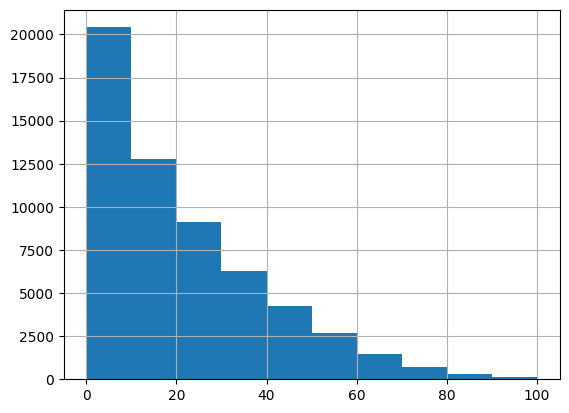

In [10]:
y_train.hist()

<Axes: >

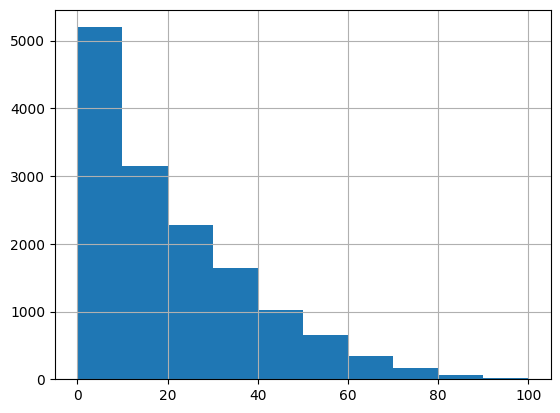

In [11]:
y_test.hist()

From the histograms above, we confirm that the distribution of ChildPoverty is similar in the training and testing sets.

In [12]:
# Quantize the training labels
y_train_cat, cuts = pd.qcut(
    y_train, q=4, labels=[1, 2, 3, 4], retbins=True
)

# Apply the same quantization to the test labels
y_test_cat = []
for y in y_test:
    if y <= cuts[1]:
        y_test_cat.append(1)
    elif y <= cuts[2]:
        y_test_cat.append(2)
    elif y <= cuts[3]:
        y_test_cat.append(3)
    else:
        y_test_cat.append(4)

In [33]:
y_test_cat = np.array(y_test_cat)

## Preprocessing and Initial Modeling

### Create MLP Classes

From https://github.com/eclarson/MachineLearningNotebooks/blob/master/08a.%20Practical_NeuralNets%20with%20Bias.ipynb

In [14]:
# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class TwoLayerPerceptronBase(object):
    def __init__(
        self, n_hidden=30, C=0.0, epochs=500, eta=0.001, random_state=None
    ):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta

    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T

        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_) * self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_)  # reshape to be W
        b1 = np.zeros((self.n_hidden, 1))

        W2_num_elems = (self.n_hidden) * self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden)
        b2 = np.zeros((self.n_output_, 1))

        return W1, W2, b1, b2

    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)

    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_ / 2.0) * np.sqrt(
            np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2)
        )

    def _cost(self, A3, Y_enc, W1, W2):
        """Get the objective function value"""
        cost = np.mean((Y_enc - A3) ** 2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term

    def _feedforward(self, X, W1, W2, b1, b2):
        """Compute feedforward step.

        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3

    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """Compute gradient step using backpropagation."""
        # vectorized backpropagation
        # This uses MSE as cost function
        V2 = -2 * (Y_enc - A3) * A3 * (1 - A3)
        V1 = A2 * (1 - A2) * (W2.T @ V2)

        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T

        gradb2 = np.sum(V2, axis=1).reshape((-1, 1))
        gradb1 = np.sum(V1, axis=1).reshape((-1, 1))

        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C

        return gradW1, gradW2, gradb1, gradb2

    def predict(self, X):
        """Predict class labels."""
        _, _, _, _, A3 = self._feedforward(
            X, self.W1, self.W2, self.b1, self.b2
        )
        y_pred = np.argmax(A3, axis=0)
        return y_pred

In [15]:
# just start with the vectorized version and minibatch
class TLPMiniBatch(TwoLayerPerceptronBase):
    def __init__(
        self,
        alpha=0.0,
        decrease_const=0.1,
        decrease_iter=10,
        shuffle=True,
        minibatches=1,
        **kwds,
    ):
        # need to add to the original initializer
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.decrease_iter = decrease_iter
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)

    def fit(self, X, y, print_progress=False, XY_test=None):
        """Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)

        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.b1, self.b2 = self._initialize_weights()

        # start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape)  # for momentum
        rho_W2_prev = np.zeros(self.W2.shape)  # for momentum

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data, self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(
                accuracy_score(y_test, self.predict(X_test))
            )
            self.val_cost_ = []

        for i in range(self.epochs):
            # adaptive learning rate
            # decrease at certain epochs
            eta = self.eta * self.decrease_const ** (
                np.floor(i / self.decrease_iter)
            )

            if print_progress > 0 and (i + 1) % print_progress == 0:
                sys.stderr.write("\rEpoch: %d/%d" % (i + 1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = (
                    X_data[idx_shuffle],
                    Y_enc[:, idx_shuffle],
                    y_data[idx_shuffle],
                )

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:
                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(
                    X_data[idx], self.W1, self.W2, self.b1, self.b2
                )

                cost = self._cost(A3, Y_enc[:, idx], self.W1, self.W2)
                mini_cost.append(
                    cost
                )  # this appends cost of mini-batch only

                # compute gradient via backpropagation
                gradW1, gradW2, gradb1, gradb2 = self._get_gradient(
                    A1=A1,
                    A2=A2,
                    A3=A3,
                    Z1=Z1,
                    Z2=Z2,
                    Y_enc=Y_enc[:, idx],
                    W1=self.W1,
                    W2=self.W2,
                )

                # simple momentum calculations

                rho_W1, rho_W2 = eta * gradW1, eta * gradW2
                self.W1 -= rho_W1 + (
                    self.alpha * rho_W1_prev
                )  # update with momentum
                self.W2 -= rho_W2 + (
                    self.alpha * rho_W2_prev
                )  # update with momentum

                # no need for momentum in bias
                # these values need to change abruptly and
                # do not influence sensitivity backward
                self.b1 -= eta * gradb1
                self.b2 -= eta * gradb2

                # update previous parameters
                rho_W1_prev, rho_W2_prev = rho_W1, rho_W2

            self.cost_.append(np.mean(mini_cost))
            self.score_.append(
                accuracy_score(y_data, self.predict(X_data))
            )

            # update if a validation set was provided
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test, yhat))

        return self

In [16]:
# to implement the new style of objective function,
# we just need to update the final layer calculation of the gradient
class TLPMiniBatchCrossEntropy(TLPMiniBatch):
    def _cost(self, A3, Y_enc, W1, W2):
        """Get the objective function value"""
        cost = -np.mean(
            np.nan_to_num(
                (
                    Y_enc * np.log(A3 + 1e-7)
                    + (1 - Y_enc) * np.log(1 - A3 + 1e-7)
                )
            )
        )
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term

    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """Compute gradient step using backpropagation."""
        # vectorized backpropagation
        # Now using cross-entropy as cost function
        V2 = A3 - Y_enc  # <- this is only line that changed
        V1 = A2 * (1 - A2) * (W2.T @ V2)

        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T

        gradb2 = np.sum(V2, axis=1).reshape((-1, 1))
        gradb1 = np.sum(V1, axis=1).reshape((-1, 1))

        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C

        return gradW1, gradW2, gradb1, gradb2

In [17]:
class TLPBetterInitial(TLPMiniBatchCrossEntropy):
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4 * np.sqrt(6.0 / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(
            -init_bound, init_bound, (self.n_hidden, self.n_features_)
        )

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between
        init_bound = 4 * np.sqrt(6 / (self.n_output_ + self.n_hidden))
        W2 = np.random.uniform(
            -init_bound, init_bound, (self.n_output_, self.n_hidden)
        )

        # set these to zero to start so that
        # they do not immediately saturate the neurons
        b1 = np.zeros((self.n_hidden, 1))
        b2 = np.zeros((self.n_output_, 1))

        return W1, W2, b1, b2

### Apply the New MLP classes to the US Census Data

In [32]:
# Initialize the mlp with default parameters
mlp = TLPBetterInitial(C=0.01, eta=0.0001)
# Fit the mlp
mlp.fit(x_train.to_numpy(), y_train_cat.to_numpy(), print_progress=10)

Epoch: 500/500

In [29]:
# Check the accuracy of the mlp on the test set
yhat = mlp.predict(x_test.to_numpy())
accuracy_score(y_true=y_test_cat, y_pred=yhat)

0.0

In [30]:
def print_result(
    nn, X_train, y_train, X_test, y_test, title="", color="red"
):
    print("=================")
    print(title, ":")
    yhat = nn.predict(X_train)
    print("Resubstitution acc:", accuracy_score(y_train, yhat))

    yhat = nn.predict(X_test)
    print("Validation acc:", accuracy_score(y_test, yhat))

    if hasattr(nn, "val_score_"):
        plt.plot(
            range(len(nn.val_score_)),
            nn.val_score_,
            color=color,
            label=title,
        )
        plt.ylabel("Validation Accuracy")
    else:
        plt.plot(
            range(len(nn.score_)), nn.score_, color=color, label=title
        )
        plt.ylabel("Resub Accuracy")

    plt.xlabel("Epochs")
    plt.tight_layout()
    plt.legend(loc="best")
    plt.grid(True)

MLP :
Resubstitution acc: 0.0
Validation acc: 0.0


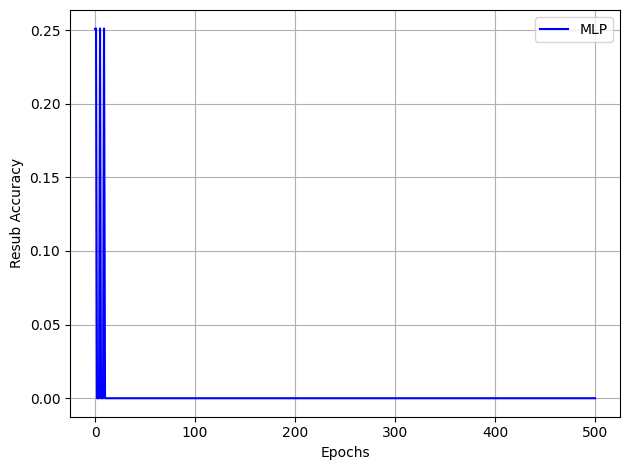

In [31]:
print_result(
    mlp,
    x_train.to_numpy(),
    y_train_cat.to_numpy(),
    x_test.to_numpy(),
    y_test_cat,
    "MLP",
    "blue",
)
plt.show()